## Using GSKY to replace datacube

### This notebook will demonstrate the use of GSKY to retrieve and display landsat data.

#### Example 4

This example plots an area, like in examples 2 and 3, and then calculates vegetation and snow cover.

**Note:** This example requires data for both True Color and False Color. We get these via two separate calls to the GSKY server.

###### Specifics

- Converting a DEA notebook example to use GSKY instaed of datacube.

- Uses WCS to get an area from a specified layer/date/bbox/time, and differs from the DEA example.
    -- where an area around a single point is calculated ("LoadingCloudfreeSentinel2andLandsat.ipynb").

- This example can only use one sensor ("ls8") instead of three sensors as DEA has used.

- The required area is specified a tile from a list that shows the bounding boxes. 

- Only one time slice can be used in WCS. 
    - You can choose from all available times in the layer.

- If you can determine a valid BBox for a date (Tip: Use TerriaMap) it can be manually typed in.

- The DEA example, using datacube, can get the data for a time range. It is not possible in GSKY.

**Author:** Arapaut V. Sivaprasad

**Date:** 22 October, 2019

### How to use

Use this notebook to display a GSKY layer corresponding to a time slice and bounding box (BBox). Instead of manually typing in the BBox, you can select a tile by its ID (e.g. 8_-31).

- Specify the name of layer in cell 2
    - layer = "landsat8_nbar_16day"
    - If necessary, uncomment its code block to see all available layers.

- Identify the available time positions (dates of data acquisitions) in cell 3
    - Give m,n values to display the range of dates (from 0 to n_times-1)
    - Give t=i to say which date to use, where i = 0 to n_times-1.

- Identify the tile ID in cell 4

- Specify the tile ID in cell 5
    - If you know another BBox with data (Tip: use TerriaMap to find) then type it in as,
        - bbox = (130.00, -27.00, 131.00, -29.00)

- Execute all cells from top to bottom.

In [12]:
##########################################################
# Author: Arapaut V. Sivaprasad.                         #
# Dates: Created: 18/10/2019; Last Modified: 18/10/2019  #
##########################################################

from owslib.wcs import WebCoverageService
from random import randrange
import os
import xarray as xr
%matplotlib inline
import numpy as np

#### Specify the GSKY capabilities end URL is below. It must be one that you can access. 

Normally there are several GSKY layers in the dataset. You must select one layer to view the data. By uncommenting its code you can display all available layers.

NOTE: The the production GSKY server does not output the 'nir', 'swir1' and 'swir2' bands. In order to provide this data, this notebook uses a development version of GSKY on the VMs. It will not work unless you are within the NCI network or connected to the NCI network via VPN.

In [13]:
# Specify the GSKY production URL here. The layer is hard coded
#gsky_url = 'https://gsky.nci.org.au/ows/dea' # Public URL
gsky_url = 'http://130.56.242.15/ows/ipynb'      # Private URL on Dev server
layer = "landsat8_nbar_16day"
wcs = WebCoverageService(gsky_url, version='1.0.0')

# Uncomment below to see all layers.
#for layer in list(wcs.contents):
#    print ("Layer Name:", layer)
#    print ("Title:", wcs[layer].title, '\n')

#### A time slice must be specified to show the layer. 

To help identify a time slice, specify the start and end values as m,n below, which will show the time slices in that range. Then specify the time slice as 't = i', where i = 0 to n_times-1

In [14]:
# To display the available time slices in any range, specify the start and end values as m,n below
time = wcs[layer].timepositions
n_times = len(time)
m = 0
n = n_times
print ("Total of", n_times,'timepositions:\n\n', time[m:n])

# The time slice whose data is to be displayed is specified below. 
t = n_times-3

Total of 9 timepositions:

 ['2013-03-19T00:00:00.000Z', '2013-04-04T00:00:00.000Z', '2013-04-20T00:00:00.000Z', '2013-05-06T00:00:00.000Z', '2013-05-22T00:00:00.000Z', '2013-06-07T00:00:00.000Z', '2013-06-23T00:00:00.000Z', '2013-07-09T00:00:00.000Z', '2013-07-25T00:00:00.000Z']


#### The Australian continent is divided into approximately 1x1 degree tiles, from -22 to +27 longitude degrees from a line through the centre of Australia.

The ID and BBox for each tile will be generated in the next box. Choose a tile by its ID to display the layer.

In [15]:
tiles_list = {}
with open("tiles_bboxes.txt") as f:
    for line in f:
        (key, val) = line.split()
        tiles_list[str(key)] = val

# Uncomment below to see all tiles and ther BBoxes
#tiles_list

#### You must select a tile to get its BBox, after verifying that the tile has some data for the chosen layer and time.

In [16]:
# If you know a BBox containing data (Tip: use TerriaMap to find out) then type it in below.
#bbox = ['130.00,-27.00,131.00,-29.00']

tiles = ['8_-31']
bbox = [tiles_list[tiles[0]]]
x = float(bbox[0][0:6])
y = float(bbox[0][7:13])
X = float(bbox[0][14:20])
Y = float(bbox[0][21:27])
X = float('%.2f'%(x + ((abs(Y - y) / 220) * 340)))
bbox = (x,y,X,Y)
bbox

(140.2, -27.36, 141.67, -28.31)

#### A call is made to the GSKY server to get the data.

In [17]:
# Construct the URL for a WCS call and send it to the GSKY server.
# Style can be False Color (fc) or True Color (tc)
# This NB uses only NetCDF and EPSG:4326. Hence, do not change these.
# If any error, the displayed URL can be opened in a browser to see the actual error message.
output = wcs.getCoverage(identifier=layer, Styles='ftc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)
print(output.geturl())

http://130.56.242.15/ows/ipynb?version=1.0.0&request=GetCoverage&service=WCS&Coverage=landsat8_nbar_16day&BBox=140.2%2C-27.36%2C141.67%2C-28.31&time=2013-06-23T00%3A00%3A00.000Z&crs=EPSG%3A4326&format=NetCDF&width=256&height=256&Styles=ftc


#### The returned data in NetCDF format is written to a file.

In [18]:
# Get the output data from GSKY and write it in a *.nc file
# A random number is inserted in the filename to prevent the browser caching the file content.
rand = str(randrange(1000))
ncfile = './output/gsky_wcs_' + rand + '.nc'
with open(ncfile, 'wb') as f:
    f.write(output.read())
ncfile    

'./output/gsky_wcs_651.nc'

#### The saved NetCDF file is read again and plotted as a map. The plot below is from the three "True Color" bands, 'red', 'green' and 'blue'

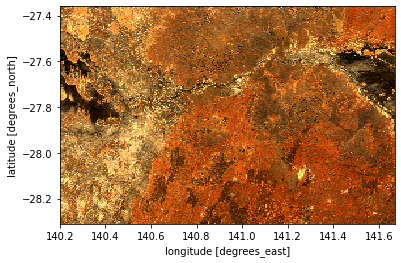

In [19]:
# Read the NetCDF file and convert it into an xarray dataset
landsat_ds = xr.open_dataset(ncfile)

# Delete the created NetCDF file
try:
    os.remove(ncfile)
except OSError:
    pass

# Plot the three bands, red, green, blue in the dataset.
landsat_ds[['Band1', 'Band2', 'Band3']].to_array().plot.imshow(robust=True)

# Uncomment below to see the raw data
#landsat_ds

### The plot below is from the three "False Color" bands, 'nir', 'swir1' and 'swir2'

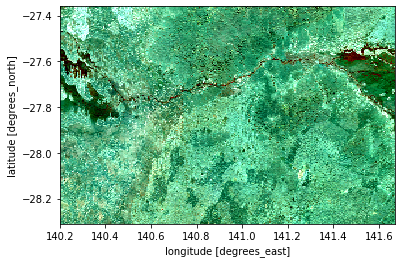

In [20]:
landsat_ds[['Band4', 'Band5', 'Band6']].to_array().plot.imshow(robust=True)

In [21]:
# View the raw data and band names
#landsat_ds

### Identify valid pixels

Here we choose a single band from the Landsat data, and test whether each pixel contains valid values using the function np.isfinite. This will give us a dataset that contains False for any invalid pixel, and True for any valid observation.

We will later use this to normalise our counts of snow to account for missing data.

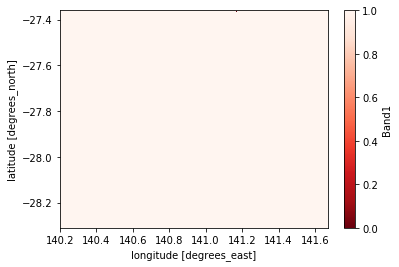

In [22]:
# Identify which pixels contain valid data in the Landsat dataset
valid_ds = np.isfinite(landsat_ds.Band1)

# Plot one sample timestep from the `valid_ds` dataset. Red below represents
# invalid pixels, due to either issues with terrain shadow on steep mountains,
# cloud cover, snow accidently mapped as cloud, or edges of Landsat overpasses
valid_ds.isel().plot(cmap='Reds_r')

### Compute Normalised Difference Snow Index (NDSI)

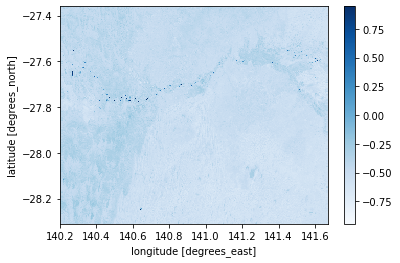

In [23]:
# Compute index by subtracting, summing and dividing the `green` and `swir1` bands
ndsi_ds = (landsat_ds.Band2 - landsat_ds.Band5) / (landsat_ds.Band2 + landsat_ds.Band5)

# Plot one sample timestep from the NDSI dataset
ndsi_ds.isel().plot(cmap='Blues')

### Compute Normalised Difference Vegetation Index (NDVI)

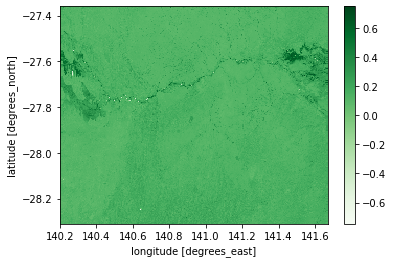

In [24]:
# Compute index by subtracting, summing and dividing the `nir` and `red` bands
ndvi_ds = (landsat_ds.Band4 - landsat_ds.Band1) / (landsat_ds.Band4 + landsat_ds.Band1)

# Plot one sample timestep from the NDSI dataset. Bright green values below
# represent growing green vegetation
ndvi_ds.isel().plot(cmap='Greens')

### Threshold NDSI and NDVI to identify snowy, non-vegetated pixels

Note: If the chosen area does not have snow cover, the plot below will be solid blue.

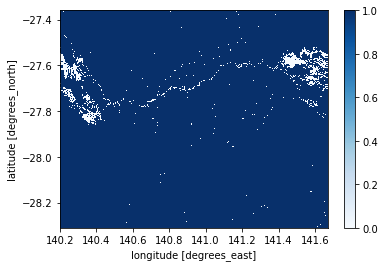

In [25]:
# Threshold that will be applied to the NDSI layer to identify pixels containing snow
ndsi_threshold = 0

# Threshold that will be applied to the NDVI layer to identify pixels containg vegetation
ndvi_threshold = 0.3

# Apply NDSI threshold defined above to identify snow (pixels with NDSI values greater than X)
snow_ds = ndsi_ds > ndsi_threshold

# Apply NDSI threshold defined above to identify snow (pixels with NDVI values less than X)
noveg_ds = ndvi_ds < ndvi_threshold

# Finally, keep only pixels that are both snowy AND non-vegetated:
snow_ds = noveg_ds & noveg_ds

# Plot the resulting layer
snow_ds.isel().plot(cmap='Blues')

### Compute time series of snow cover normalised by valid data

Note: There is no 'time' dimension in the NetCDF file. Hence, this plot may not make much sense.

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.4747921, 0.5747921, 0.6747921, 0.7747921, 0.8747921, 0.9747921,
        1.0747921, 1.1747921, 1.2747921, 1.3747921, 1.4747921]),
 <a list of 10 Patch objects>)

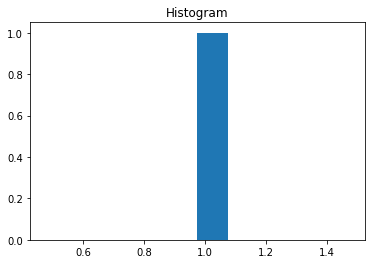

In [26]:
# First, calculate the number of snowy pixels in the study area for each timestep
snow_sum = snow_ds.sum(dim=['lon', 'lat'])

# Then calculate the number of pixels in the study area with valid data
# for each time step
valid_sum = valid_ds.sum(dim=['lon', 'lat'])

# By dividing the number of snowy pixels by the number of valid pixels, we can
# compute a normalised percentage land cover that accounts for missing/invalid data
snow_prop = (snow_sum / valid_sum)

# Plot a line graph of snow cover across time as a proportion of the study area
snow_prop.plot()

### Plot snow accumulation for every pixel

As well as plotting a time series of snow cover across time, we can assess how frequently areas of the study area were covered by snow during the time period being analysed.

Note: There is no 'time' dimension in the NetCDF file. Hence, this plot may not make much sense.

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([63882.5, 63882.6, 63882.7, 63882.8, 63882.9, 63883. , 63883.1,
        63883.2, 63883.3, 63883.4, 63883.5]),
 <a list of 10 Patch objects>)

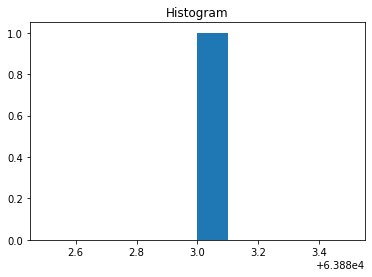

In [27]:
# This time, calculate the number of snowy observations for every pixel
# by taking a sum along the 'time' dimension
snow_sum_perpixel = snow_ds.sum()

# Similarly, compute the number of valid observations for each pixel
# by taking the sum of valid observations along the 'time' dimension
valid_sum_perpixel = valid_ds.sum()

# We can plot the raw number of snowy observations per pixel:
snow_sum_perpixel.plot()